In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import os

In [51]:
def named_frame(frame: cv2.typing.MatLike, number: int) -> cv2.typing.MatLike:
    named_frame = frame.copy()
    cv2.putText(
        named_frame,
        str(number),
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    return named_frame

In [183]:
# Lviv human detect
video_path = "/home/michael/Stuff/ffmpeg-tutorial/videos/lex-33-lviv/lviv-2024-06-27/13:18/right_camera.mp4"
start_time_in_seconds = 5 * 60 + 4

# st. Alexius artifacts
# video_path = "/home/michael/Stuff/ffmpeg-tutorial/videos/lex-28-st_alexius/2024-07-10/2/left_camera.mp4"
# start_time_in_seconds = 25

# Lviv real sense artifacts
# video_path = "/home/michael/Stuff/ffmpeg-tutorial/videos/lex-33-lviv/lviv-2024-07-10/2/external.mp4"
# start_time_in_seconds = 1

# Lviv stairs humans
# video_path = "/home/michael/Stuff/ffmpeg-tutorial/videos/lex-33-lviv/lviv-2024-07-10/1/external.mp4"
# start_time_in_seconds = 8 * 60 + 27

IS_PIXEL_MOVING_THRESHOLD = 50
AMOUNT_OF_MOVING_PIXELS_THRESHOLD = 20

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
start_frame_number = int(start_time_in_seconds * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number - 1)

current_frame_idx = start_frame_number
ret, previous_frame = cap.read()
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow("Frame", named_frame(frame, current_frame_idx))

        start_time = time.time()

        prev_gray = cv2.cvtColor(previous_frame, cv2.COLOR_RGB2GRAY)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        #diff = cv2.subtract(gray, prev_gray)
        diff = np.abs(np.float32(gray) - np.float32(prev_gray))
        diff = np.uint8(diff)
        ret, diff_clear = cv2.threshold(diff, IS_PIXEL_MOVING_THRESHOLD, 255, cv2.THRESH_BINARY)
        diff_clear = cv2.medianBlur(diff_clear, 3)
        amount_of_moving_pixels = len(diff_clear[diff_clear > 0])

        end_time = time.time()
        print(f"Run in {(end_time - start_time)*1000} ms")

        cv2.imshow("Diff", named_frame(np.clip(diff * 2, 0, 255), current_frame_idx))
        cv2.imshow("Clear Diff", named_frame(diff_clear, amount_of_moving_pixels))

        key = cv2.waitKey(0) & 0xFF
        if key == ord("q"):
            break
        elif key == 81:  # left arrow
            current_frame_idx -= 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_idx)
        elif key == 83:  # right arrow
            current_frame_idx += 1

        previous_frame = frame
finally:
    cap.release()
    cv2.destroyAllWindows()

Run in 0.9946823120117188 ms
Run in 1.1563301086425781 ms
Run in 0.9508132934570312 ms
Run in 0.9233951568603516 ms
Run in 2.1216869354248047 ms
Run in 1.020669937133789 ms
Run in 3.298044204711914 ms
Run in 3.50189208984375 ms
Run in 0.9236335754394531 ms
Run in 1.0166168212890625 ms
Run in 0.9491443634033203 ms
Run in 0.9694099426269531 ms
Run in 0.9446144104003906 ms
Run in 1.0852813720703125 ms
Run in 0.9937286376953125 ms
Run in 0.8928775787353516 ms
Run in 0.9233951568603516 ms
Run in 1.0752677917480469 ms
Run in 1.0483264923095703 ms
Run in 1.2328624725341797 ms
Run in 0.8895397186279297 ms
Run in 1.0170936584472656 ms
Run in 0.9150505065917969 ms
Run in 1.2464523315429688 ms
Run in 0.9794235229492188 ms
Run in 1.0862350463867188 ms
Run in 0.9284019470214844 ms
Run in 1.0328292846679688 ms
Run in 1.0192394256591797 ms
Run in 0.9350776672363281 ms
Run in 1.0228157043457031 ms
Run in 0.9081363677978516 ms
Run in 0.9806156158447266 ms
Run in 1.1489391326904297 ms
Run in 0.878095626

In [204]:
def moving_pixels(curr_frame: cv2.typing.MatLike, prev_frame: cv2.typing.MatLike):
    IS_PIXEL_MOVING_THRESHOLD = 50

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
    # diff = cv2.subtract(gray, prev_gray)
    diff = np.abs(np.float32(curr_gray) - np.float32(prev_gray))
    diff = np.uint8(diff)
    ret, diff_clear = cv2.threshold(
        diff, IS_PIXEL_MOVING_THRESHOLD, 255, cv2.THRESH_BINARY
    )
    diff_clear = cv2.medianBlur(diff_clear, 3)
    return len(diff_clear[diff_clear > 0])

Ratio: 0.5254029789838809


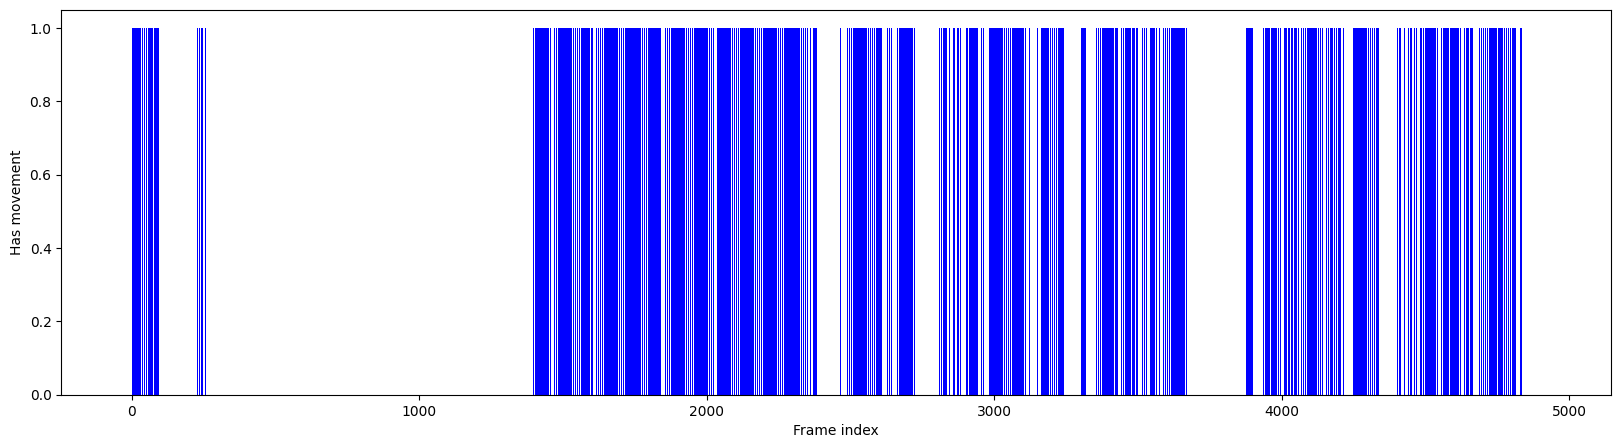

In [215]:
video_path = "/home/michael/Stuff/ffmpeg-tutorial/videos/lex-28-st_alexius/2024-07-10/3/left_camera.mp4"

IS_PIXEL_MOVING_THRESHOLD = 50
AMOUNT_OF_MOVING_PIXELS_THRESHOLD = 20

video_time = 0
processing_time = 0

frame_indices = []
has_movement_vals = []

cap = cv2.VideoCapture(video_path)

current_frame_idx = 0
frame_indices.append(current_frame_idx)
has_movement_vals.append(False)
ret, previous_frame = cap.read()

while True:
    ret, frame = cap.read()
    if not ret:
        break
    current_frame_idx += 1

    amount_of_moving_pixels = moving_pixels(frame, previous_frame)
    frame_indices.append(len(frame_indices))
    has_movement_vals.append(
        amount_of_moving_pixels > AMOUNT_OF_MOVING_PIXELS_THRESHOLD
    )

    previous_frame = frame

vals = np.array(has_movement_vals)
plt.figure(figsize=(20, 5))
plt.bar(frame_indices, has_movement_vals, color="blue")
plt.xlabel("Frame index")
plt.ylabel("Has movement")
print("Ratio:", len(vals[vals > 0]) / len(vals))

In [214]:
base_dir = "/home/michael/Stuff/ffmpeg-tutorial/videos/lex-28-st_alexius/2024-07-10/"

IS_PIXEL_MOVING_THRESHOLD = 50
AMOUNT_OF_MOVING_PIXELS_THRESHOLD = 20

dirs = os.listdir(base_dir)
dirs = sorted([int(num) for num in dirs])
dirs = dirs[:]
video_time = 0
processing_time = 0

frame_indices = []
has_movement_vals = []
ratios = []
for dir in dirs:
    video_path = f"{base_dir}/{dir}/left_camera.mp4"

    cap = cv2.VideoCapture(video_path)

    current_frame_idx = 0
    frame_indices.append(current_frame_idx)
    has_movement_vals.append(False)
    ret, previous_frame = cap.read()
    start_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        current_frame_idx += 1

        amount_of_moving_pixels = moving_pixels(frame, previous_frame)
        frame_indices.append(len(frame_indices))
        has_movement_vals.append(
            amount_of_moving_pixels > AMOUNT_OF_MOVING_PIXELS_THRESHOLD
        )

        previous_frame = frame

    end_time = time.time()

    video_time += cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    processing_time += end_time - start_time

    vals = np.array(has_movement_vals)
    ratio = len(vals[vals > 0]) / len(vals)
    ratios.append(ratio)
    print(f"processed {dir}/{len(dirs)},", "ratio", f"{ratio:.2f},", "avg ratio", f"{np.mean(ratios):.2f}")
    frame_indices = []
    has_movement_vals = []

print("Video Time:", f"{video_time:.2f}s")
print("Proc Time:", f"{processing_time:.2f}s")
print("Total Ratio:", f"{np.mean(ratios):.2f}")

processed 1/29, ratio 0.05, avg ratio 0.05
processed 2/29, ratio 0.21, avg ratio 0.13
processed 3/29, ratio 0.53, avg ratio 0.26


KeyboardInterrupt: 